## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torch.utils.data import random_split
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torchdata.datapipes as dp
import torch
import torch.nn as nn
import torch.optim as optim
import time
import spacy
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
!pip install beautifulsoup4
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
!python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, GRU, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
from itertools import chain
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Conv1D
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Bidirectional
!pip install transformers
!pip install transformers[torch] -U
!pip install transformers datasets torch
!pip install accelerate -U
!pip install transformers -U
!pip install accelerate -U
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
from collections import Counter
from itertools import chain

In [2]:
file_path = '/content/FinancialNewsDB.csv'
columns = ['Sentiment', 'Headline']

try:
    data = pd.read_csv(file_path, encoding='utf-8', names=columns, header=None)
except UnicodeDecodeError:
    try:
        data = pd.read_csv(file_path, encoding='latin1', names=columns, header=None)
    except Exception as e:
        print(f"An error occurred: {str(e)}")

pd.set_option('max_colwidth', None)
data.dropna(inplace = True)
data.head(3)

,Sentiment,Headline
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."


neutral     2879
positive    1363
negative     604
Name: Sentiment, dtype: int64


<ipython-input-3-104224d83b1b>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Sentiment', data=data, palette='magma', order=order)


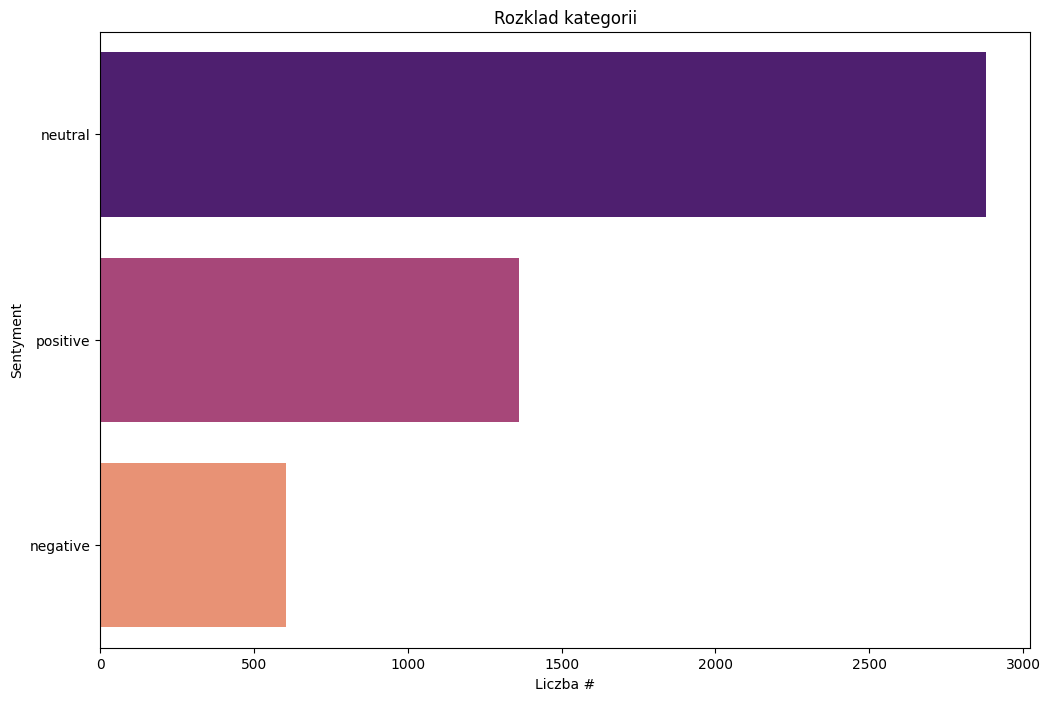

In [3]:
# Czyszczenie

def czyszczenie(tekst):
    tekst = tekst.lower()

    html_matcher = re.compile(r'http?\S+|www\.\S+')
    tekst = html_matcher.sub(r'', tekst)

    tekst = re.sub(r'@\w+', '', tekst)
    tekst = re.sub(r'[^a-zA-Z\s]', '', tekst)

    return tekst

data['Czysty_Headline'] = data['Headline'].apply(czyszczenie)
print(data['Sentiment'].value_counts())

data['Sentiment'] = data['Sentiment'].astype('category')
order = data['Sentiment'].value_counts().index

plt.figure(figsize=(12, 8))
sns.countplot(y='Sentiment', data=data, palette='magma', order=order)
plt.xlabel('Liczba #')
plt.ylabel('Sentyment')
plt.title('Rozklad kategorii')
plt.show()

In [4]:
# Tokenizacja Lemmatyzacja
matcher = re.compile(r"[\w]+|[*]+|[,.?!;:]")
def tokenizer(text):
    return matcher.findall(text)

tokenizer = get_tokenizer('spacy', 'en_core_web_sm')

def tokenizacja(headline):
    tokens = [
        token.lower()
        for token in tokenizer(headline)
        if not nlp.vocab[token.lower()].is_stop
        and (token.lower().isalpha() or token.lower() == "****")
        and len(token.lower()) > 2
    ]
    return tokens

def lemmatyzacja(tokens):
    lemmatized_tokens = [
        token.lemma_
        for token in nlp(" ".join(tokens))
        if not nlp.vocab[token.lemma_].is_stop
        and (token.lemma_.isalpha() or token.lemma_ == "****")
        and len(token.lemma_) > 2
    ]
    return lemmatized_tokens

data['Ztokenizowany_Headline'] = data['Czysty_Headline'].apply(tokenizacja)
data['Lemmat'] = data['Ztokenizowany_Headline'].apply(lemmatyzacja)

sentyment_mapa = {'positive': 1, 'neutral': 0, 'negative': -1}
data['Sentyment_N'] = data['Sentiment'].map(sentyment_mapa)

data.head(5)

,Sentiment,Headline,Czysty_Headline,Ztokenizowany_Headline,Lemmat,Sentyment_N
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",according to gran the company has no plans to move all production to russia although that is where the company is growing,"[according, gran, company, plans, production, russia, company, growing]","[accord, gran, company, plan, production, russia, company, grow]",0
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",technopolis plans to develop in stages an area of no less than square meters in order to host companies working in computer technologies and telecommunications the statement said,"[technopolis, plans, develop, stages, area, square, meters, order, host, companies, working, computer, technologies, telecommunications, statement, said]","[technopoli, plan, develop, stage, area, square, meter, order, host, company, work, computer, technology, telecommunication, statement]",0
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility contrary to earlier layoffs the company contracted the ranks of its office workers the daily postimees reported,"[international, electronic, industry, company, elcoteq, laid, tens, employees, tallinn, facility, contrary, earlier, layoffs, company, contracted, ranks, office, workers, daily, postimees, reported]","[international, electronic, industry, company, elcoteq, lay, employee, tallinn, facility, contrary, early, layoff, company, contract, rank, office, worker, daily, postimee, report]",-1
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,with the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability,"[new, production, plant, company, increase, capacity, meet, expected, increase, demand, improve, use, raw, materials, increase, production, profitability]","[new, production, plant, company, increase, capacity, meet, expect, increase, demand, improve, use, raw, material, increase, production, profitability]",1
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",according to the company s updated strategy for the years basware targets a longterm net sales growth in the range of with an operating profit margin of of net sales,"[according, company, updated, strategy, years, basware, targets, longterm, net, sales, growth, range, operating, profit, margin, net, sales]","[accord, company, update, strategy, year, basware, target, longterm, net, sale, growth, range, operating, profit, margin, net, sale]",1


In [5]:
X = data['Lemmat']
y = data['Sentiment']

# Kodowanie etykiet
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

def build_vocab(texts, min_count=3):
    #  Spłaszczanie tekstu i liczenie słów
    flattened_texts = list(chain.from_iterable(texts))
    word_counts = Counter(flattened_texts)
    # Filtrowanie słów i przypisywanie indeksów
    vocab = {
        word: idx + 1
        for idx, (word, count)
        in enumerate((w, c) for w, c in word_counts.items() if c >= min_count)
    }
    return vocab

vocab = build_vocab(X_train, min_count=3)
max_features = len(vocab)

Epoch 1/20
85/85 [==============================] - 65s 642ms/step - loss: 1.1804 - accuracy: 0.3476 - val_loss: 1.0950 - val_accuracy: 0.2091
Epoch 2/20
85/85 [==============================] - 51s 602ms/step - loss: 1.0239 - accuracy: 0.5039 - val_loss: 0.8932 - val_accuracy: 0.6200
Epoch 3/20
85/85 [==============================] - 47s 551ms/step - loss: 0.8115 - accuracy: 0.6565 - val_loss: 0.8599 - val_accuracy: 0.6186
Epoch 4/20
85/85 [==============================] - 47s 551ms/step - loss: 0.6142 - accuracy: 0.7589 - val_loss: 0.8769 - val_accuracy: 0.6392
Epoch 5/20
85/85 [==============================] - 46s 548ms/step - loss: 0.4266 - accuracy: 0.8374 - val_loss: 0.8566 - val_accuracy: 0.6627
Epoch 6/20
85/85 [==============================] - 47s 559ms/step - loss: 0.3294 - accuracy: 0.8809 - val_loss: 0.9464 - val_accuracy: 0.6657
Epoch 7/20
85/85 [==============================] - 47s 559ms/step - loss: 0.2496 - accuracy: 0.9093 - val_loss: 0.9727 - val_accuracy: 0.6892

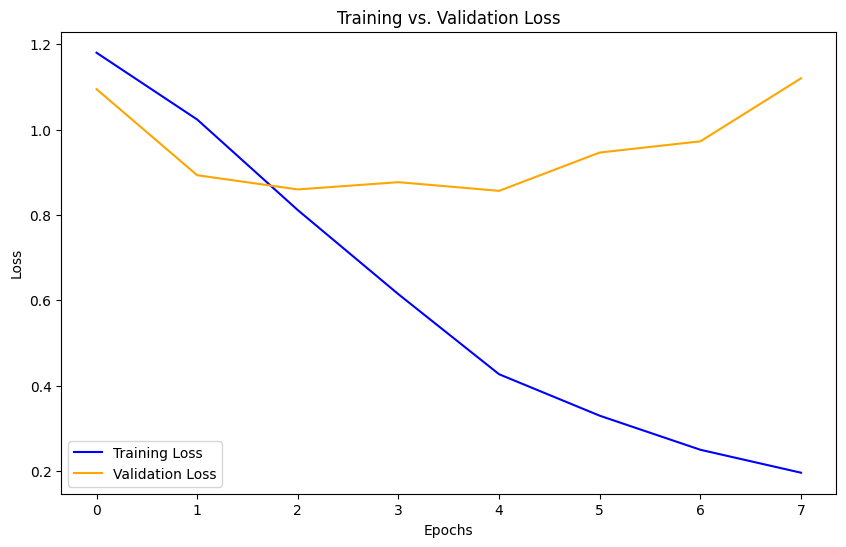

46/46 [==============================] - 3s 51ms/step
Dokładność testowa: 0.6856946354883081
Ważony F-score: 0.6805295781133608


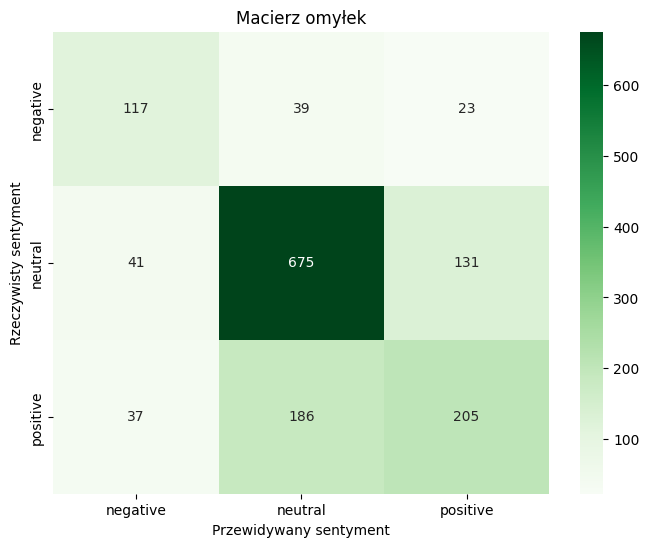

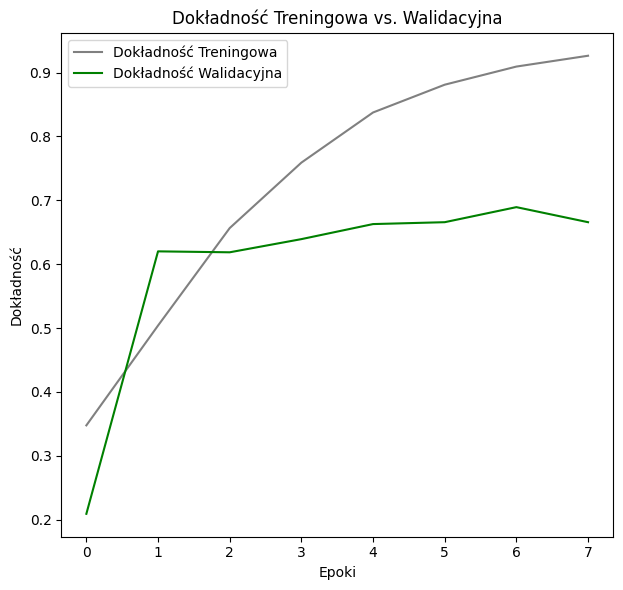

In [9]:
# LSTM A
# Tokenizacja (i padding)
max_len = 80
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

# Wagi klas
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Konwersja na słownik
class_weight_dict = dict(enumerate(class_weights))

# LSTM
model = Sequential()
model.add(Embedding(input_dim=max_features + 1, output_dim=256, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.3))
model.add(Dense(7, activation='softmax'))

# Kompilacja z wagami
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Earlystoppping, żeby uniknąć overfitu
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trenowanie modelu z wagami
history = model.fit(X_train_padded, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja
y_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Dokładność testowa: {accuracy}")
print(f"Ważony F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz omyłek')
plt.xlabel('Przewidywany sentyment')
plt.ylabel('Rzeczywisty sentyment')
plt.show()

# Wykres dokładności
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność Treningowa', color='Grey')
plt.plot(history.history['val_accuracy'], label='Dokładność Walidacyjna', color='Green')
plt.title('Dokładność Treningowa vs. Walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/10
85/85 [==============================] - 33s 330ms/step - loss: 1.0087 - accuracy: 0.5507 - val_loss: 0.9533 - val_accuracy: 0.5876
Epoch 2/10
85/85 [==============================] - 25s 297ms/step - loss: 0.6527 - accuracy: 0.7700 - val_loss: 0.7792 - val_accuracy: 0.6686
Epoch 3/10
85/85 [==============================] - 24s 283ms/step - loss: 0.2994 - accuracy: 0.9031 - val_loss: 0.8872 - val_accuracy: 0.6775
Epoch 4/10
85/85 [==============================] - 13s 157ms/step - loss: 0.1748 - accuracy: 0.9425 - val_loss: 0.9115 - val_accuracy: 0.6996
Epoch 5/10
85/85 [==============================] - 16s 192ms/step - loss: 0.1124 - accuracy: 0.9639 - val_loss: 1.0437 - val_accuracy: 0.6627


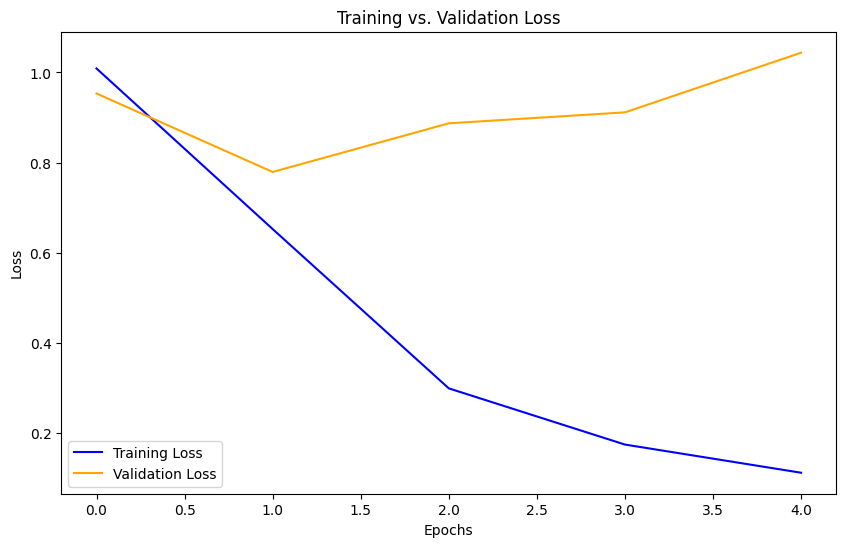

46/46 [==============================] - 2s 27ms/step
Dokładność testowa: 0.703576341127923
Ważony F-score: 0.705602430597149


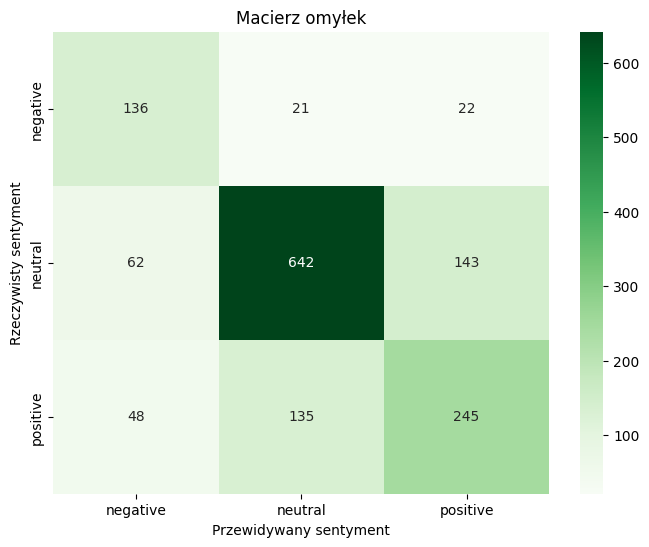

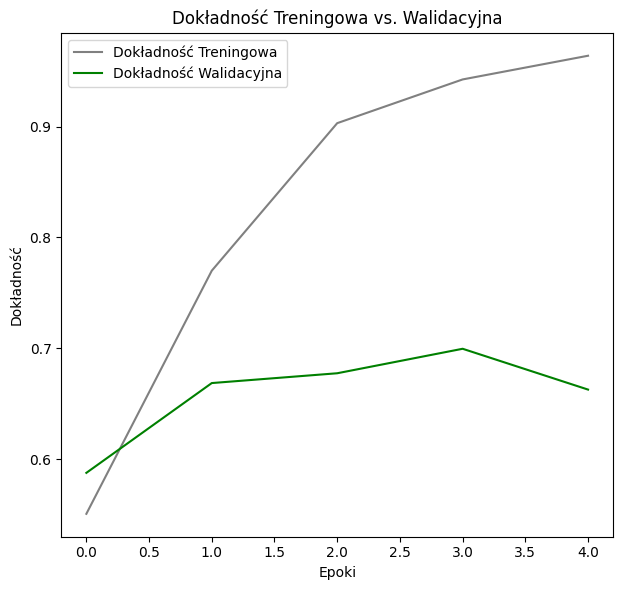

In [ ]:
# LSTM B
# Tokenizacja i padding

max_len = 50  # Can be comfortably set to 80
max_features = 20000  # Assuming max_features is defined somewhere

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary
class_weight_dict = dict(enumerate(class_weights))

# LSTM B
model_lstm_b = Sequential()
model_lstm_b.add(Embedding(input_dim=max_features + 1, output_dim=128, input_length=max_len))
model_lstm_b.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_lstm_b.add(Dense(3, activation='softmax'))  # Assuming there are 3 classes

# Kompilowanie
model_lstm_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trening z wagami
history = model_lstm_b.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja
y_prob = model_lstm_b.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Dokładność testowa: {accuracy}")
print(f"Ważony F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz omyłek')
plt.xlabel('Przewidywany sentyment')
plt.ylabel('Rzeczywisty sentyment')
plt.show()

# Wykres dokładności
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność Treningowa', color='Grey')
plt.plot(history.history['val_accuracy'], label='Dokładność Walidacyjna', color='Green')
plt.title('Dokładność Treningowa vs. Walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/20
85/85 [==============================] - 13s 118ms/step - loss: 1.0597 - accuracy: 0.5529 - val_loss: 0.8679 - val_accuracy: 0.6421
Epoch 2/20
85/85 [==============================] - 8s 94ms/step - loss: 0.5694 - accuracy: 0.7973 - val_loss: 0.6740 - val_accuracy: 0.7172
Epoch 3/20
85/85 [==============================] - 8s 95ms/step - loss: 0.1701 - accuracy: 0.9440 - val_loss: 0.8091 - val_accuracy: 0.7320
Epoch 4/20
85/85 [==============================] - 8s 89ms/step - loss: 0.0677 - accuracy: 0.9808 - val_loss: 0.9024 - val_accuracy: 0.7275
Epoch 5/20
85/85 [==============================] - 7s 87ms/step - loss: 0.0357 - accuracy: 0.9912 - val_loss: 1.0031 - val_accuracy: 0.7158


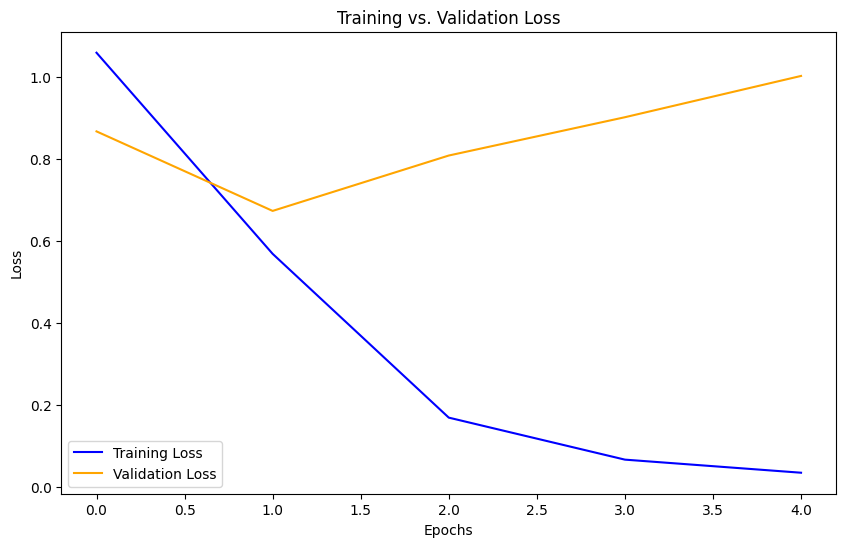

46/46 [==============================] - 1s 15ms/step
Test Accuracy: 0.7585969738651994
Weighted F-score: 0.7554793485718443


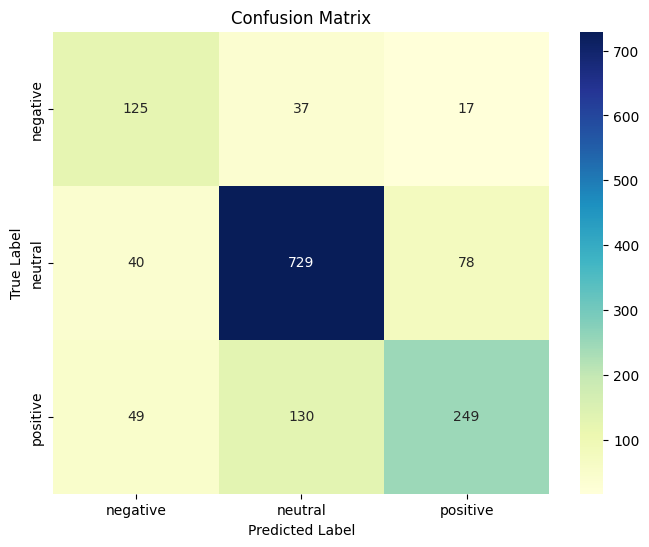

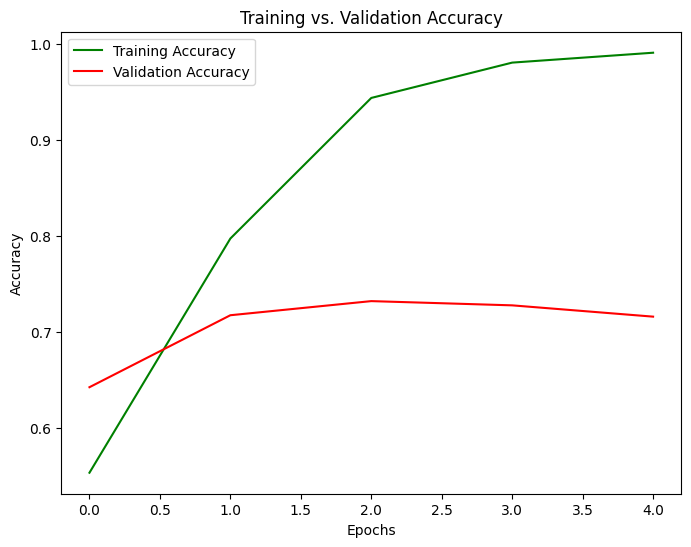

In [ ]:
# CNN A
# Model_cnn_a - budowa
model_cnn_a = Sequential()
model_cnn_a.add(Embedding(input_dim=max_features + 1, output_dim=128, input_length=max_len))
model_cnn_a.add(Conv1D(256, 3, activation='relu'))
model_cnn_a.add(GlobalMaxPooling1D())
model_cnn_a.add(Dense(128, activation='relu'))
model_cnn_a.add(Dense(64, activation='relu'))
model_cnn_a.add(Dense(3, activation='softmax'))

# Dobieranie wag, kompilacja z wagami klas
model_cnn_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Problem overfittingu, earlystopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trenowanie model_cnn_au
history = model_cnn_a.fit(X_train_padded, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja
y_prob = model_cnn_a.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

# Metryki
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy}")
print(f"Weighted F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Wykres dokładności treningowej i walidacyjnej
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/10
85/85 [==============================] - 7s 72ms/step - loss: 1.0419 - accuracy: 0.6329 - val_loss: 0.9717 - val_accuracy: 0.6215
Epoch 2/10
85/85 [==============================] - 6s 69ms/step - loss: 0.5754 - accuracy: 0.8209 - val_loss: 0.6838 - val_accuracy: 0.7158
Epoch 3/10
85/85 [==============================] - 6s 69ms/step - loss: 0.1754 - accuracy: 0.9462 - val_loss: 0.7385 - val_accuracy: 0.7231
Epoch 4/10
85/85 [==============================] - 6s 70ms/step - loss: 0.0631 - accuracy: 0.9834 - val_loss: 0.8642 - val_accuracy: 0.6907
Epoch 5/10
85/85 [==============================] - 6s 71ms/step - loss: 0.0408 - accuracy: 0.9908 - val_loss: 0.9343 - val_accuracy: 0.7069


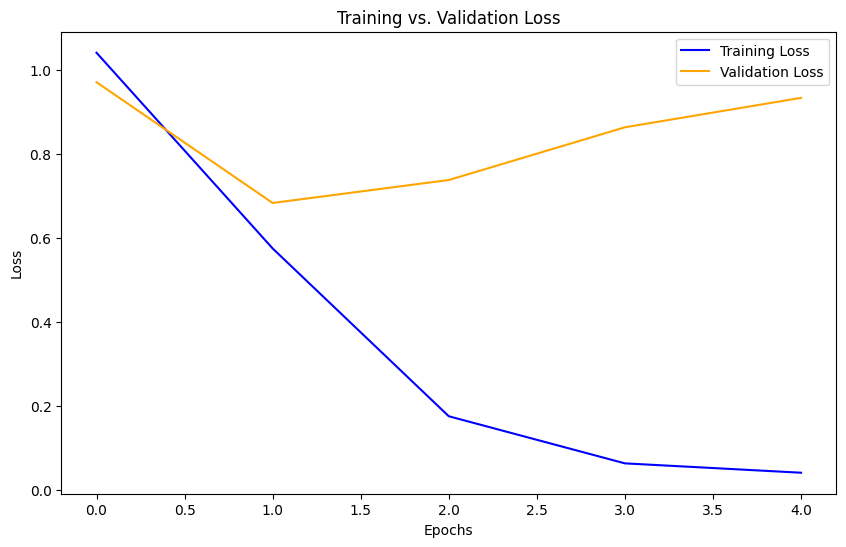

46/46 [==============================] - 1s 11ms/step
Test Accuracy: 0.7283356258596974
Weighted F-score: 0.7319167137116847


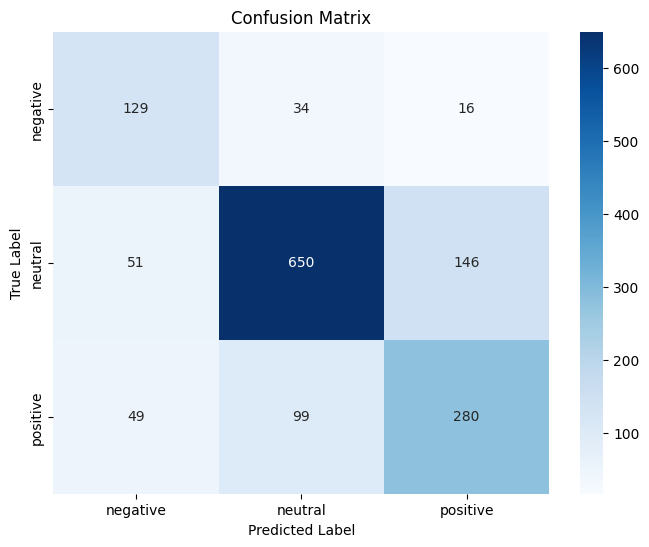

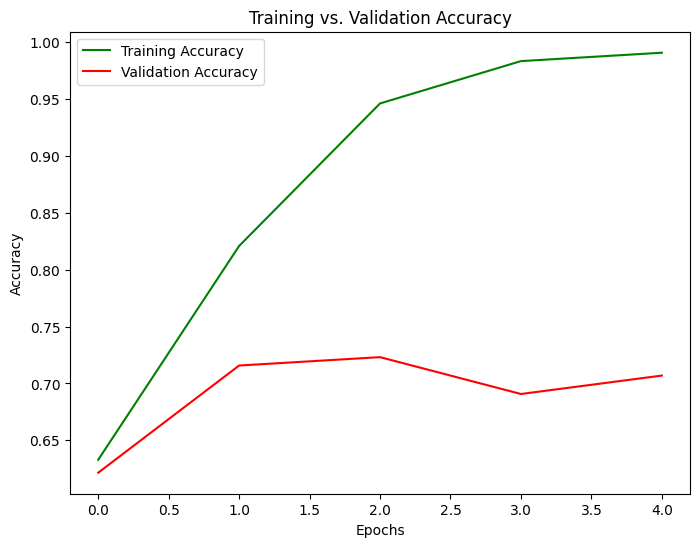

In [ ]:
# CNN B
model_cnn_b = Sequential()
model_cnn_b.add(Embedding(input_dim=max_features + 1, output_dim=128, input_length=max_len))
model_cnn_b.add(Conv1D(128, 3, activation='relu'))
model_cnn_b.add(GlobalMaxPooling1D())
model_cnn_b.add(Dense(64, activation='relu'))
model_cnn_b.add(Dense(3, activation='softmax'))  # Assuming you have 3 classes (negative, neutral, positive)

# Dobieranie wag do model_cnn_bu
model_cnn_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Problem overfittingu, earlystopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trenowanie model_cnn_bu z wagami klas
history = model_cnn_b.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja model_cnn_bu
y_prob = model_cnn_b.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

# Obliczenie metryk
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy}")
print(f"Weighted F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Wykres dokładności danych treningowych i walidacyjnych
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

--2024-02-03 17:05:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-03 17:05:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-03 17:05:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

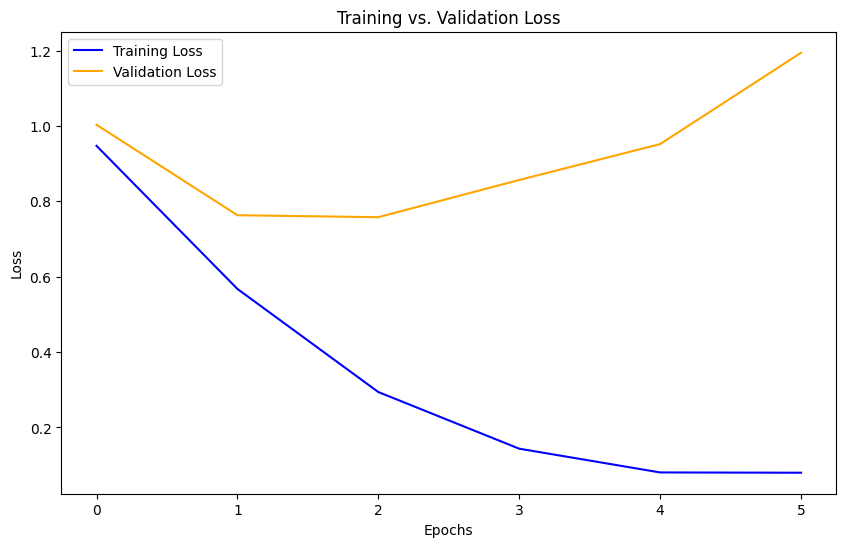

46/46 [==============================] - 0s 6ms/step
Test Accuracy: 0.7248968363136176
Weighted F-score: 0.728705027632438


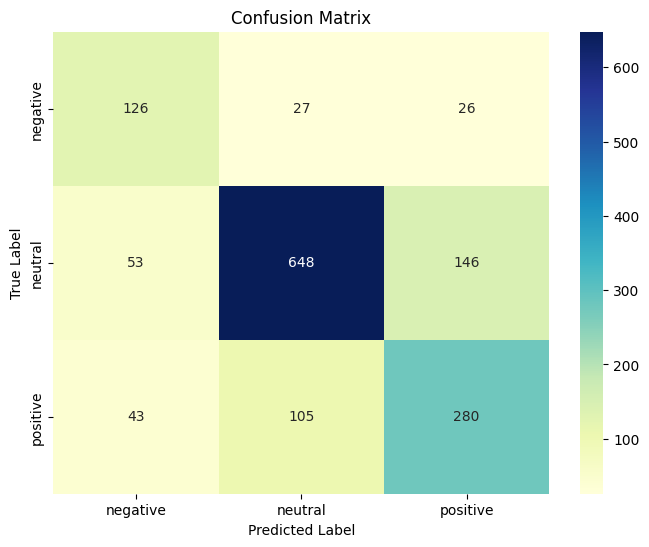

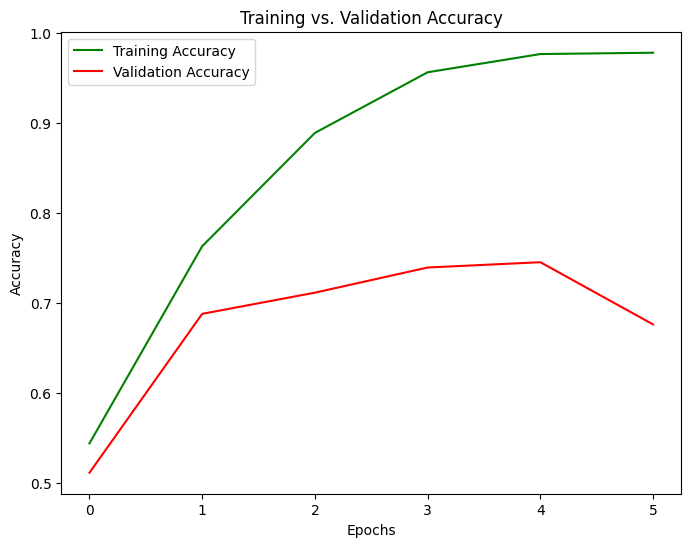

In [11]:
# # CNN A z Embeddingami
# # GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
# # !wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove.6B.zip
# # !unzip glove.42B.300d.zip
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

embedding_index = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

max_len = 128
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)


# Model_cnn_ae
model_cnn_ae = Sequential()
model_cnn_ae.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_cnn_ae.add(Conv1D(256, 3, activation='relu'))
model_cnn_ae.add(GlobalMaxPooling1D())
model_cnn_ae.add(Dense(128, activation='relu'))
model_cnn_ae.add(Dense(64, activation='relu'))
model_cnn_ae.add(Dense(3, activation='softmax'))

# Dobieranie wag, kompilacja z wagami klas
model_cnn_ae.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Problem overfittingu, earlystopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trenowanie model_cnn_aeu
history = model_cnn_ae.fit(X_train_padded, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja
y_prob = model_cnn_ae.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

# Metryki
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy}")
print(f"Weighted F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Wykres dokładności treningowej i walidacyjnej
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/10
85/85 [==============================] - 7s 55ms/step - loss: 1.0157 - accuracy: 0.5330 - val_loss: 0.8622 - val_accuracy: 0.6642
Epoch 2/10
85/85 [==============================] - 4s 50ms/step - loss: 0.5771 - accuracy: 0.7943 - val_loss: 0.6997 - val_accuracy: 0.6966
Epoch 3/10
85/85 [==============================] - 5s 56ms/step - loss: 0.2629 - accuracy: 0.9064 - val_loss: 0.7944 - val_accuracy: 0.6966
Epoch 4/10
85/85 [==============================] - 4s 53ms/step - loss: 0.1198 - accuracy: 0.9631 - val_loss: 0.8661 - val_accuracy: 0.7261
Epoch 5/10
85/85 [==============================] - 5s 53ms/step - loss: 0.0576 - accuracy: 0.9830 - val_loss: 1.0279 - val_accuracy: 0.7143


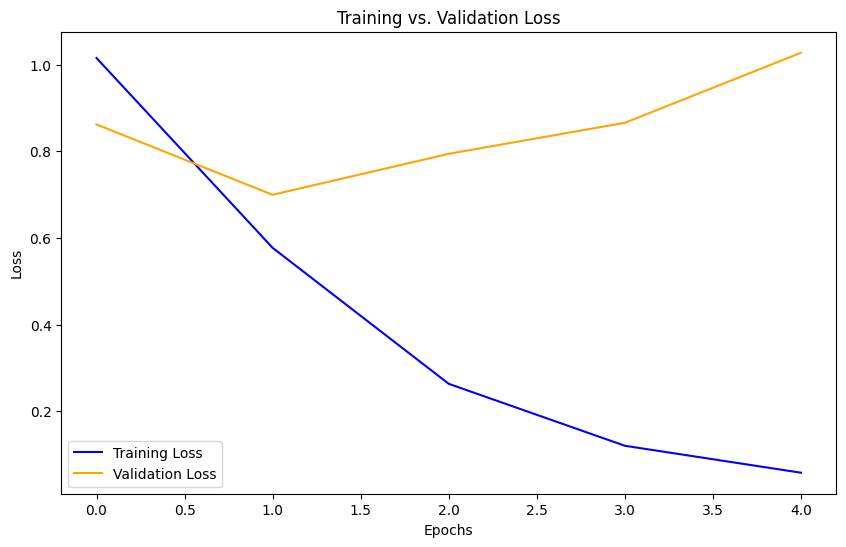

46/46 [==============================] - 1s 16ms/step
Test Accuracy: 0.7248968363136176
Weighted F-score: 0.7303795132489247


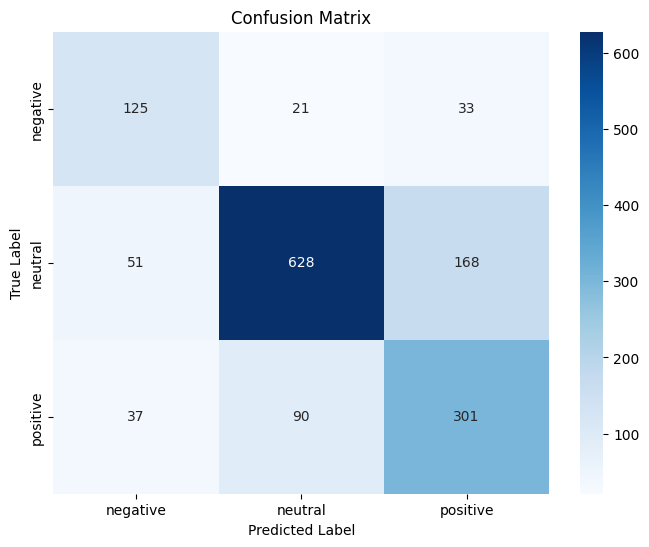

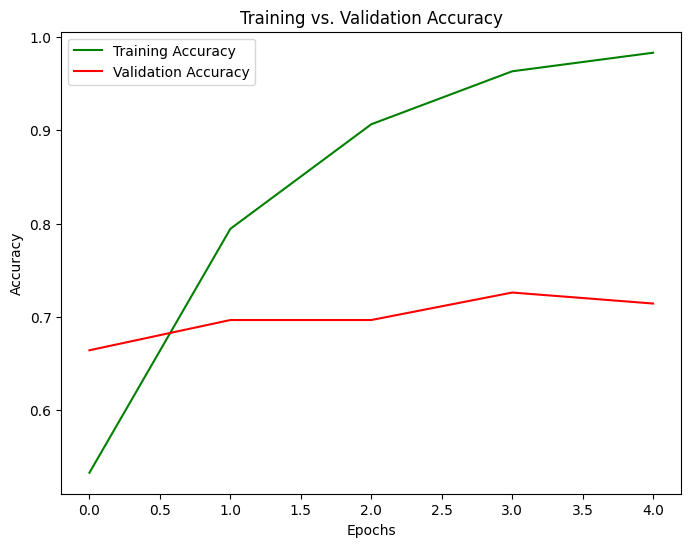

In [ ]:
# CNN B z Embeddingami
model_cnn_be = Sequential()
model_cnn_be.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_cnn_be = Sequential()
model_cnn_be.add(Embedding(input_dim=max_features + 1, output_dim=128, input_length=max_len))
model_cnn_be.add(Conv1D(128, 3, activation='relu'))
model_cnn_be.add(GlobalMaxPooling1D())
model_cnn_be.add(Dense(64, activation='relu'))
model_cnn_be.add(Dense(3, activation='softmax'))

# Dobieranie wag do model_cnn_beu
model_cnn_be.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Problem overfittingu, earlystopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trenowanie model_cnn_beu z wagami klas
history = model_cnn_be.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja model_cnn_beu
y_prob = model_cnn_be.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

# Obliczenie metryk
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy}")
print(f"Weighted F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Wykres dokładności danych treningowych i walidacyjnych
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/20
85/85 [==============================] - 102s 1s/step - loss: 1.0348 - accuracy: 0.5065 - val_loss: 0.8022 - val_accuracy: 0.6657
Epoch 2/20
85/85 [==============================] - 101s 1s/step - loss: 0.8007 - accuracy: 0.6425 - val_loss: 0.8551 - val_accuracy: 0.6333
Epoch 3/20
85/85 [==============================] - 91s 1s/step - loss: 0.7083 - accuracy: 0.6900 - val_loss: 0.6949 - val_accuracy: 0.6878
Epoch 4/20
85/85 [==============================] - 105s 1s/step - loss: 0.6143 - accuracy: 0.7324 - val_loss: 0.7645 - val_accuracy: 0.6686
Epoch 5/20
85/85 [==============================] - 94s 1s/step - loss: 0.5560 - accuracy: 0.7615 - val_loss: 0.7134 - val_accuracy: 0.7054
Epoch 6/20
85/85 [==============================] - 83s 978ms/step - loss: 0.4828 - accuracy: 0.7895 - val_loss: 0.7964 - val_accuracy: 0.6465


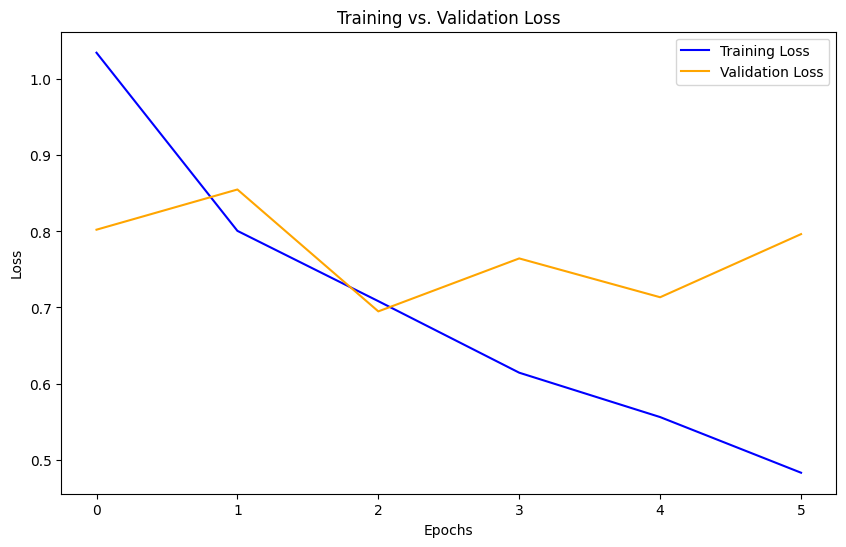

46/46 [==============================] - 3s 64ms/step
Test Accuracy: 0.7083906464924347
Weighted F-score: 0.7102514689157325


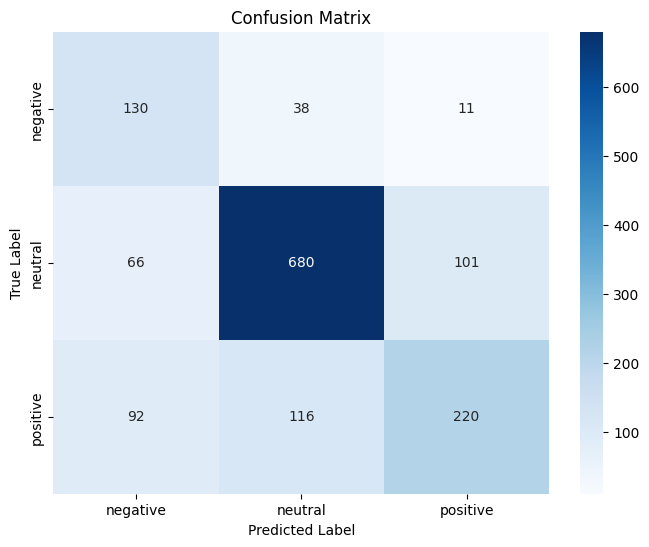

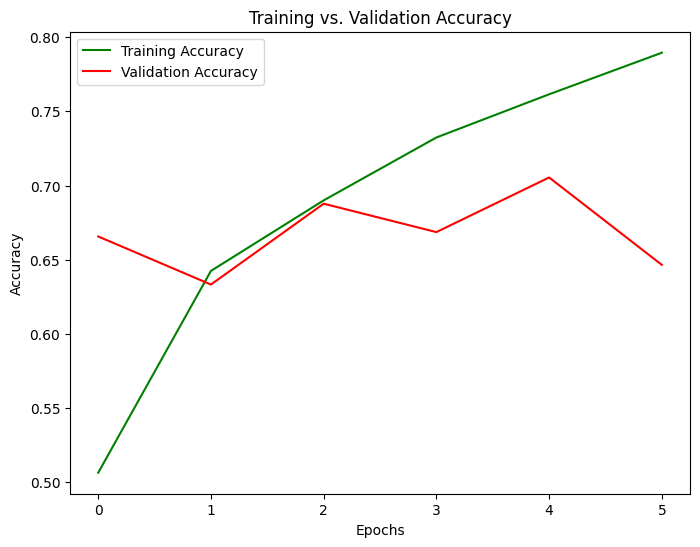

In [ ]:
# LSTM A z Embeddingami

model = Sequential()
model.add(Embedding(input_dim=max_features + 1, output_dim=256, input_length=max_len))
model_lstm_ae = Sequential()
model_lstm_ae.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_lstm_ae.add(LSTM(128, dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
model_lstm_ae.add(LSTM(64, dropout=0.2, recurrent_dropout=0.3))
model_lstm_ae.add(Dense(7, activation='softmax'))

# Wagi klas
model_lstm_ae.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Trening model_lstm_aeu
history = model_lstm_ae.fit(X_train_padded, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping], class_weight=class_weight_dict)

# Wykres strat training i validation
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Ewaluacja model_lstm_aeu
y_prob = model_lstm_ae.predict(X_test_padded)
y_pred = np.argmax(y_prob, axis=1)

# Obliczenie metryk
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy}")
print(f"Weighted F-score: {f1}")

# Macierz omyłek
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Wykres dokładności danych treningowych i walidacyjnych
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# MOJ BERT
data = pd.read_csv('FinancialNewsDB.csv', encoding='ISO-8859-1')
# headers = ["Sentiment", "Headline"]
# data.columns = headers
# data.to_feather('FinancialNewsDB.feather')

# Konwersja DataFrame do Dataset Hugging Face i podział
dataset_ = Dataset.from_pandas(data)
dataset = dataset_.train_test_split(test_size=0.1)  # Podział na zbiory treningowy i testowy

# Definicja checkpointa i rozmiaru batcha
model_checkpoint = 'distilbert-base-uncased'
batch_size = 128

# Inicjalizacja tokenizera
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Funkcja tokenizacji
# def process(examples):
#     return tokenizer(examples['Headline'], truncation=True, padding='max_length', max_length=512)
def process(examples):
    tokenized_inputs = tokenizer(examples["Headline"], truncation=True, padding="max_length", max_length=512, return_tensors="tf")
    # Przekształcenie etykiet na odpowiedni format numeryczny, np. 0 i 1
    sentiment_to_label = {"negative": 0, "neutral": 1, "positive": 2}
    tokenized_inputs["labels"] = [sentiment_to_label[label] for label in examples["Sentiment"]]
    return tokenized_inputs

# Tokenizacja zbioru danych
train_ds = dataset["train"].map(process, batched=True)
eval_ds = dataset["test"].map(process, batched=True)

# Definicja modelu
num_labels = 3
bert_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)  # Model dla klasyfikacji

# # Argumenty treningowe
# args = TrainingArguments(
#     output_dir=f'{model_checkpoint}_sentiment_analysis',
#     evaluation_strategy='epoch',
#     save_strategy='epoch',
#     learning_rate=2e-5,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=5,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model='accuracy',  # Metryka do wyboru najlepszego modelu
# )

args = TrainingArguments(
    output_dir=f'{model_checkpoint}_sentiment_analysis',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Zmniejszony rozmiar wsadu
    per_device_eval_batch_size=16,  # Zmniejszony rozmiar wsadu
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    #fp16=True,  # Włącz trening FP16
    gradient_accumulation_steps=2,  # Użyj akumulacji gradientu, jeśli potrzebujesz większego efektywnego rozmiaru wsadu
)

# Definicja funkcji obliczającej metryki
metric = load_metric('accuracy')  # Ładowanie metryki dokładności

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)  # Obliczanie metryk

# Inicjalizacja Trenera
trainer = Trainer(
    model=bert_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Funkcja metryk
)

# Trening modelu
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,No log,0.309415,0.868041
2,No log,0.301748,0.884536
4,0.241800,0.343047,0.896907


TrainOutput(global_step=680, training_loss=0.1977821293999167, metrics={'train_runtime': 418.4694, 'train_samples_per_second': 52.095, 'train_steps_per_second': 1.625, 'total_flos': 2878251637997568.0, 'train_loss': 0.1977821293999167, 'epoch': 4.98})

In [ ]:
# Test użycia
# Funkcja do oceny sentymentu
# def predict(text, bert_model, tokenizer):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')  # Ustawienie urządzenia
#     bert_model.to(device)
#     inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
#     with torch.no_grad():
#         outputs = bert_model(**inputs)
#         predictions = torch.argmax(outputs.logits, dim=-1)
#     return 'pozytywny' if predictions.item() == 1 else 'negatywny'  # Zwraca 'pozytywny' lub 'negatywny'

def predict(text, bert_model, tokenizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
    bert_model.to(device)
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    # 3 etykiety
    sentiment_map = {0: 'negatywny', 1: 'neutralny', 2: 'pozytywny'}
    sentiment_label = sentiment_map[predictions.item()]

    return sentiment_label

text = "Meta shares up 20% as investors cheer dividends and $50bn buyback"
print(predict(text, bert_model, tokenizer))

pozytywny


In [ ]:
# Test użycia
# Funkcja do oceny sentymentu
def predict_other(text, model, tokenizer, max_len=128):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    prediction = model.predict(padded_sequence)

    # Tłumaczenie predykcji na etykietę
    sentiment_class = np.argmax(prediction, axis=1)[0]
    sentiment_map = {0: 'negatywny', 1: 'neutralny', 2: 'pozytywny'}
    sentiment_label = sentiment_map[sentiment_class]

    return sentiment_label

text = "Meta shares up 20% as investors cheer dividends and $50bn buyback"
print(predict_other(text, model_cnn_ae, tokenizer))

pozytywny
